<a href="https://colab.research.google.com/github/robinrb7/RealWorldSizing/blob/main/DPT_depth_real_Sizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Install necessary libraries (run this in a Colab cell)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers
!pip install pillow requests supervision exifread


Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6

In [2]:
!pip uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.6.0+cu118
Uninstalling torch-2.6.0+cu118:
  Successfully uninstalled torch-2.6.0+cu118
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124


In [3]:
# Install PyTorch with CUDA 11.8
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (27 kB)
Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl (848.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 74.7 MB/s eta 0:00:00


In [4]:
# Step 2: Import Libraries
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import exifread
from transformers import (
    AutoProcessor, AutoModelForZeroShotObjectDetection,
    SamModel, SamProcessor, DPTForDepthEstimation, DPTImageProcessor
)
import supervision as sv

In [5]:
# Step 3: Load All Models
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# Grounding DINO
detection_processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")
detection_model = AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-base").to(device)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

In [7]:
# SAM
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
sam_model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [10]:
# Metric Depth Model (DPT-Large-NYU)
# Depth Estimation with DPT-Large (NYU Depth V2)
depth_model_id = "Intel/dpt-large"  # Using DPT-Large fine-tuned on NYU Depth V2
depth_processor = DPTImageProcessor.from_pretrained(depth_model_id)
depth_model = DPTForDepthEstimation.from_pretrained(depth_model_id).to("cuda")

preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Step 4: Helper Functions
def get_focal_length(image_path):
    """Extract focal length from EXIF metadata in mm"""
    with open(image_path, "rb") as f:
        tags = exifread.process_file(f)
    if "EXIF FocalLength" in tags:
        return float(tags["EXIF FocalLength"].values[0])
    return None

In [12]:
def convert_focal_to_pixels(focal_mm, image_width_px, sensor_width_mm=10.4):
    """Convert focal length from mm to pixels"""
    return (focal_mm * image_width_px) / sensor_width_mm

In [13]:
def calculate_pixel_dimensions(mask):
    """Calculate object width/height from SAM mask"""
    y_indices, x_indices = np.where(mask > 0)
    if len(y_indices) == 0:
        return 0, 0
    return np.max(x_indices) - np.min(x_indices) + 1, np.max(y_indices) - np.min(y_indices) + 1


In [14]:
def predict_metric_depth(image):
    """Predict depth in meters using DPT-Large-NYU"""
    inputs = depth_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = depth_model(**inputs)
        prediction = torch.nn.functional.interpolate(
            outputs.predicted_depth.unsqueeze(1),
            size=image.size[::-1],
            mode="bicubic",
            align_corners=False,
        )
    return prediction.squeeze().cpu().numpy()  # Depth in meters


In [15]:
# Step 5: Main Processing Pipeline
def process_image(image_path, text_prompt="a bottle. a cup.", sensor_width_mm=10.4):
    # Load image
    image = Image.open(image_path)
    width_px, height_px = image.size

    # Get focal length
    focal_mm = get_focal_length(image_path)
    if focal_mm is None:
        raise ValueError("Focal length not found in EXIF metadata")
    focal_px = convert_focal_to_pixels(focal_mm, width_px, sensor_width_mm)

    # Detect objects
    inputs = detection_processor(images=image, text=text_prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = detection_model(**inputs)
    results = detection_processor.post_process_grounded_object_detection(
        outputs, inputs.input_ids, box_threshold=0.3, text_threshold=0.3, target_sizes=[(height_px, width_px)]
    )
    boxes = results[0]["boxes"].cpu().numpy()
    labels = results[0]["labels"]
    scores = results[0]["scores"].cpu().numpy()

    # Predict metric depth
    depth_map = predict_metric_depth(image)

    # Process each detected object
    for idx, (box, label, score) in enumerate(zip(boxes, labels, scores)):
        if score < 0.25:
            continue

        # Get segmentation mask
        input_points = [[[(box[0] + box[2]) / 2, (box[1] + box[3]) / 2]]]
        inputs_sam = sam_processor(
            image, input_points=input_points, return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            outputs_sam = sam_model(**inputs_sam)
        masks = sam_processor.image_processor.post_process_masks(
            outputs_sam.pred_masks.cpu(),
            inputs_sam["original_sizes"].cpu(),
            inputs_sam["reshaped_input_sizes"].cpu(),
        )
        mask = masks[0][0, 0].numpy()  # Binary mask

        # Calculate object dimensions
        pixel_width, pixel_height = calculate_pixel_dimensions(mask)

        # Get object depth (median depth within mask)
        object_depth = np.median(depth_map[mask > 0])

        # Calculate real-world size
        real_width = (pixel_width * object_depth) / focal_px
        real_height = (pixel_height * object_depth) / focal_px

        # Print results
        print(f"\nObject {idx+1} ({label}):")
        print(f"- Pixel size: {pixel_width:.0f}x{pixel_height:.0f} px")
        print(f"- Depth: {object_depth:.2f} meters")
        print(f"- Real size: {real_width:.3f}m (width) x {real_height:.3f}m (height)")

        # Visualization
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Segmentation Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(depth_map, cmap='viridis')
        plt.colorbar(label='Depth (meters)')
        plt.title("Depth Map")
        plt.axis('off')

        plt.show()


Object 1 (a bottle):
- Pixel size: 557x2128 px
- Depth: 31.21 meters
- Real size: 10.987m (width) x 41.975m (height)


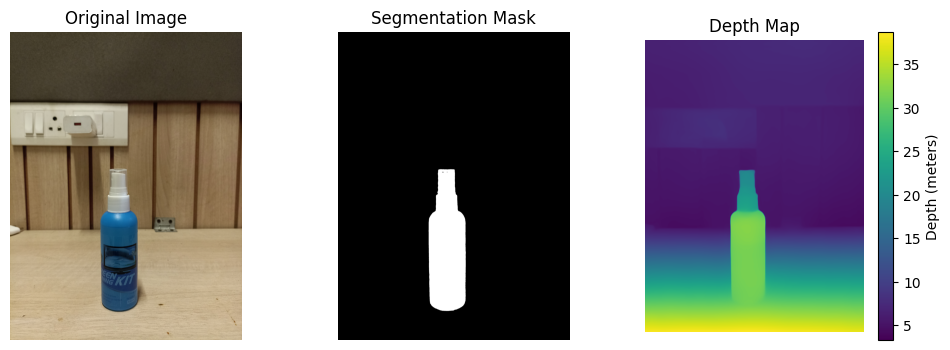

In [16]:
# Step 6: Run the Pipeline
image_path = "/content/ex4.jpg"  # Replace with your image
process_image(image_path, text_prompt="a bottle.", sensor_width_mm=10.4)